In [98]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [101]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

In [103]:
data = pd.read_csv('ScrappedPostsData.csv')

In [104]:
data.dropna(inplace=True)

In [105]:
data.drop(['Unnamed: 0','Upvote_ratio'], axis=1, inplace=True)

Title word count lengths: 
 Min: 1 
 Max: 210 
 Average: 10.85932518597237


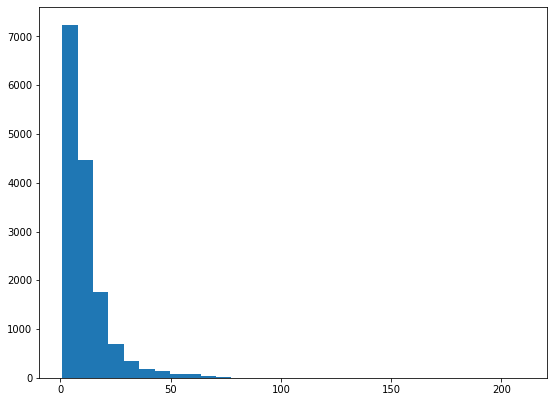

In [106]:
plt.figure(figsize=(20,15))
plt.subplot(221)
title_word_lengths = [len(str(data.Title.iloc[i]).split(' ')) for i in range(len(data))]
max_title_word_length = max(title_word_lengths)
min_title_word_length = min(title_word_lengths)
average_title_word_length = sum(title_word_lengths)/len(title_word_lengths)
plt.hist(title_word_lengths, bins = 30)
print('Title word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_title_word_length, max_title_word_length, average_title_word_length))


In [107]:
# data preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_preprocess(text):
    text = re.sub(r'[^\w\s]', '', text) 
    l_text = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    stem_words = [stemmer.stem(w) for w in l_text]
    lemma_words = [lemmatizer.lemmatize(w) for w in l_text]

    return " ".join(lemma_words)

data['Title'] = data['Title'].map(lambda com : text_preprocess(com))

In [108]:
data.head()

,Title,Score,Gilded,Over_18,Number_of_Comments,neg,neu,pos,compound
0,people continue wearing mask pandemic end,40466,0,False,12754,0.000,1.000,0.000,0.0000
1,dear covid fuck covid icu nurse,15456,2,False,635,0.315,0.450,0.234,-0.2263
2,thailand elephant rescued abuse brought sanctu...,36866,1,False,645,0.088,0.607,0.305,0.8860
3,philippine poised lift age consent sex decade ...,54377,0,False,2278,0.059,0.766,0.176,0.3818
4,happening trump supporter trying destroy orego...,45937,1,False,4021,0.154,0.570,0.276,0.4215


In [109]:
i = 0

predicted_value = []

while i<len(data):
  if (data.loc[i]['compound'] >= 0.5):
    predicted_value.append('positive')
    i = i+1

  elif (data.loc[i]['compound'] >= 0) & (data.loc[i]['compound'] <= 0.5):
    predicted_value.append('neutral')
    i = i+1

  elif (data.loc[i]['compound'] <= 0):
    predicted_value.append('negative')
    i = i+1

In [110]:
data['Predicted_value'] = predicted_value

In [111]:
data.drop(['neg', 'neu', 'pos', 'compound'], axis=1, inplace=True)

In [112]:
X = data.drop(['Score'], axis=1)
y = data['Score']

In [113]:
lengths = max([len(x) for x in X.Title])
lengths

278

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [115]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train["Title"])

In [116]:
train_title = tokenizer.texts_to_sequences(X_train["Title"])
test_title = tokenizer.texts_to_sequences(X_test["Title"])

vocab_size = len(tokenizer.word_index) + 1

In [117]:
indixes = tokenizer.word_index
tokens = {k:[indixes[k]] for k in indixes}
df_tokens = pd.DataFrame(tokens)
df_tokens.to_csv('tokens.csv', header=True, index=False)

In [118]:
maxlen = 300

train_title = pad_sequences(train_title, padding='post', maxlen=maxlen)
test_title = pad_sequences(test_title, padding='post', maxlen=maxlen)

In [120]:
embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [121]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [122]:
df = pd.DataFrame(data=embedding_matrix.astype(float))
df.to_csv('embedding_matrix.csv', sep=' ', header=True, float_format='%.2f', index=False)

In [123]:
train_new = {}
for i, sentence in enumerate(train_title):
    vectors = []
    for n in sentence:
        vectors.append(embedding_matrix[n])
    train_new[i] = vectors

In [124]:
test_new = {}
for i, sentence in enumerate(test_title):
    vectors = []
    for n in sentence:
        vectors.append(embedding_matrix[n])
    test_new[i] = vectors

In [125]:
X_train_df = []
for key in train_new:
    arr = np.array(train_new[key])
    X_train_df.append(np.mean(arr, axis=0))

In [126]:
X_test_df = []
for key in test_new:
    arr = np.array(test_new[key])
    X_test_df.append(np.mean(arr, axis=0))

In [127]:
X_train_df = pd.DataFrame(np.array(X_train_df))
X_test_df = pd.DataFrame(np.array(X_test_df))

In [128]:
from sklearn.preprocessing import OneHotEncoder

categories = ['Over_18', 'Predicted_value']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[categories])
pickle.dump(enc, open('one_hot.pkl','wb'))

In [129]:
col_names = [j for sub in enc.categories_ for j in sub] 

In [130]:
col_names

[False, True, 'negative', 'neutral', 'positive']

In [131]:
train_encoded = enc.transform(X_train[categories])
test_encoded = enc.transform(X_test[categories])

In [132]:
X_train.drop(["Title", 'Over_18', 'Predicted_value'], axis=1, inplace=True)
X_test.drop(["Title", 'Over_18', 'Predicted_value'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [133]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [134]:
train = pd.DataFrame(train_encoded.todense(), columns=col_names)
test = pd.DataFrame(test_encoded.todense(), columns=col_names)

In [135]:
train.head()

,False,True,negative,neutral,positive
0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0


In [136]:
X_train = pd.concat([X_train, X_train_df, train], axis=1)
X_test = pd.concat([X_test, X_test_df, test], axis=1)

In [137]:
X_train.head()

,Gilded,Number_of_Comments,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,False,True,negative,neutral,positive
0,0,39,-0.001442,0.002572,0.001396,-0.000855,0.001007,-0.000152,-0.000654,-0.000342,0.000799,-0.002514,-0.001796,0.000149,0.004344,0.000058,0.002888,-0.000628,-0.001018,0.000273,0.001533,0.002309,0.003437,0.001069,-0.000544,-0.000029,0.001838,-0.001242,-0.001644,-0.001304,0.000287,0.000121,0.003186,-0.001177,-0.000711,0.001419,0.003261,0.000331,-0.000243,-0.001107,...,0.003832,0.004244,-0.001411,0.001332,0.000647,0.000923,-0.003411,-0.001714,-0.001157,0.000289,-0.002904,0.001654,0.001972,-0.004411,0.000266,0.003280,-0.001016,-0.001442,-0.002754,-0.009053,-0.005863,-0.000298,-0.002147,0.000307,-0.003503,0.001274,-0.002454,-0.000896,-0.000431,-0.003577,-0.000712,-0.002249,-0.002615,0.003140,0.001254,1.0,0.0,0.0,1.0,0.0
1,0,25,0.001152,-0.000055,0.000286,-0.002464,-0.001223,0.001911,0.000202,0.001630,0.001593,-0.001790,-0.000927,-0.000070,0.002760,0.005914,0.002542,0.002074,-0.001778,0.000789,0.003108,0.001323,-0.000030,0.000412,-0.005082,-0.000129,0.009926,0.004685,-0.003142,-0.000973,0.007245,-0.002394,0.001977,0.004322,0.005463,0.002817,-0.000317,0.000195,0.000675,-0.000570,...,-0.000374,0.002152,0.000168,-0.000879,-0.002507,-0.002335,0.000090,0.001730,-0.000831,-0.000963,-0.000786,-0.003303,0.002347,0.001552,0.000040,-0.000638,0.000891,0.001120,0.001272,-0.005514,-0.001737,0.001396,0.002255,-0.000374,0.003300,-0.000205,-0.000076,-0.000068,0.002739,0.001856,0.001418,-0.003537,0.001183,0.001878,0.000346,1.0,0.0,0.0,1.0,0.0
2,0,32,0.001058,0.002922,-0.000213,-0.002265,-0.002557,0.003873,-0.000871,0.001327,-0.004929,0.003158,0.002672,0.000358,-0.002374,0.004117,-0.001034,0.000669,0.001088,-0.003424,0.000294,0.002256,0.000198,0.002201,-0.002456,0.000588,0.002622,0.002554,-0.002652,-0.000251,-0.002618,0.000373,0.002589,0.004451,-0.002851,0.000735,0.000821,0.003574,-0.000632,0.000665,...,-0.000024,0.003853,0.000752,0.000699,0.000972,-0.000039,0.000154,0.002223,0.000663,0.003008,-0.000383,-0.001463,-0.000419,-0.000994,-0.001060,0.005584,-0.004343,0.000123,-0.005201,-0.002135,0.002429,-0.001983,-0.003800,0.001324,0.000682,-0.000196,-0.001794,0.000896,-0.003757,-0.000507,-0.001019,-0.000696,-0.001129,0.000829,0.000500,1.0,0.0,0.0,1.0,0.0
3,0,46,0.002586,-0.002090,-0.000494,-0.000723,0.000721,-0.000667,0.000564,-0.002557,0.004949,-0.006141,0.001817,0.005486,-0.002309,-0.003773,0.002510,-0.006349,0.001289,-0.003406,-0.004589,-0.001085,0.001606,0.003017,-0.003863,0.005617,-0.000793,-0.001102,0.000576,-0.002225,0.003030,-0.001523,-0.002886,0.005291,-0.002822,0.002866,0.001827,-0.000533,-0.002735,0.001282,...,0.002163,0.004352,-0.000555,0.001888,-0.003806,0.002032,-0.004048,-0.004106,-0.006275,-0.002760,0.001775,0.000121,-0.001698,-0.004419,-0.003410,0.006606,-0.003119,-0.000067,-0.001392,-0.009955,0.003875,-0.002600,-0.001378,-0.001347,-0.000579,0.005433,0.005295,0.003561,0.009520,-0.000654,-0.000201,0.000349,-0.004536,-0.000481,0.002201,1.0,0.0,0.0,1.0,0.0
4,1,74,0.002095,-0.001389,0.002128,0.000576,-0.000136,0.003090,0.001196,0.000207,-0.003432,-0.002451,0.001173,-0.000225,-0.002000,0.004050,0.003206,-0.000789,-0.004403,-0.001892,-0.003310,0.000135,0.005087,0.000371,-0.002490,0.000266,0.002875,0.008118,0.000994,-0.000345,0.001632,-0.002089,0.003973,0.006256,0.003019,-0.000028,0.001693,-0.000426,0.001638,-0.001947,...,0.000099,0.002910,0.002968,-0.001254,-0.003910,-0.002701,-0.000285,0.001452,-0.004989,0.004137,0.001980,-0.002116,-0.003051,-0.003008,0.001575,0.003356,-0.001350,-0.003678,-0.002062,-0.010014,-0.001772,-0.002111,-0.002755,0.000406,0.003798,-0.000424,0.001249,-0.000580,0.003762,0.005452,0.004116,-0.000643,0.000204,0.003167,-0.000351,1.0,0.0,0.0,1.0,0.0


In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn import metrics

In [139]:
lm=LinearRegression()   
lm = lm.fit(X_train,y_train)

#Traindata Predictions
train_pred = lm.predict(X_train)

#testdata predictions
test_pred = lm.predict(X_test)


RMSE_test = np.sqrt(mean_squared_error(y_test, test_pred))
RMSE_train= np.sqrt(mean_squared_error(y_train,train_pred))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',lm.score(X_train, y_train))
print('RSquared value on test:',lm.score(X_test, y_test))

RMSE TrainingData =  7869.979472326438
RMSE TestData =  8948.74957123513
--------------------------------------------------
RSquared value on train: 0.2771574493592297
RSquared value on test: 0.07858682970448438


In [140]:
DT=DecisionTreeRegressor()
DT.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [141]:
#predicting train
train_preds=DT.predict(X_train)
#predicting on test
test_preds=DT.predict(X_test)

In [142]:
RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',DT.score(X_train, y_train))
print('RSquared value on test:',DT.score(X_test, y_test))

RMSE TrainingData =  497.8744612234056
RMSE TestData =  9950.356640873139
--------------------------------------------------
RSquared value on train: 0.9971070814288798
RSquared value on test: -0.13921842507236204


In [143]:
RF=RandomForestRegressor(n_jobs=-1)
RF.fit(X_train,y_train)

#predicting train
train_preds1=RF.predict(X_train)
#predicting on test
test_preds1=RF.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds1)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds1)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',RF.score(X_train, y_train))
print('RSquared value on test:',RF.score(X_test, y_test))

RMSE TrainingData =  2584.2517693774957
RMSE TestData =  6865.266062991941
--------------------------------------------------
RSquared value on train: 0.9220589674147153
RSquared value on test: 0.45769394652236606


In [144]:
RF=RandomForestRegressor(n_jobs=-1)
RF.fit(X_train,y_train)

pickle.dump(RF, open('rf.pkl','wb'))

In [145]:
knn=KNeighborsRegressor()
knn.fit(X_train,y_train)

#predicting train
train_preds2=knn.predict(X_train)
#predicting on test
test_preds2=knn.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds2)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds2)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',knn.score(X_train, y_train))
print('RSquared value on test:',knn.score(X_test, y_test))

RMSE TrainingData =  6042.175764031128
RMSE TestData =  7451.644931659574
--------------------------------------------------
RSquared value on train: 0.5739277793990758
RSquared value on test: 0.36109834692091725


In [146]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor

In [147]:
lasso = LassoCV(cv=10).fit(X_train, y_train)


#predicting train
train_preds3=lasso.predict(X_train)
#predicting on test
test_preds3=lasso.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds3)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds3)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',lasso.score(X_train, y_train))
print('RSquared value on test:',lasso.score(X_test, y_test))

RMSE TrainingData =  8034.932006086684
RMSE TestData =  9049.800344322846
--------------------------------------------------
RSquared value on train: 0.24653874864045822
RSquared value on test: 0.05765983503903849


In [148]:
ridge = RidgeCV(cv=10).fit(X_train, y_train)
#predicting train
train_preds4=ridge.predict(X_train)
#predicting on test
test_preds4=ridge.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds4)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds4)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',ridge.score(X_train, y_train))
print('RSquared value on test:',ridge.score(X_test, y_test))


RMSE TrainingData =  7889.842912421455
RMSE TestData =  8939.214392384392
--------------------------------------------------
RSquared value on train: 0.27350400671135056
RSquared value on test: 0.08054937397011164


In [149]:
elastic_net = ElasticNetCV(cv = 10).fit(X_train, y_train)
#predicting train
train_preds5=elastic_net.predict(X_train)
#predicting on test
test_preds5=elastic_net.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds5)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds5)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',elastic_net.score(X_train, y_train))
print('RSquared value on test:',elastic_net.score(X_test, y_test))

RMSE TrainingData =  8042.3260607591355
RMSE TestData =  9002.04898892087
--------------------------------------------------
RSquared value on train: 0.2451513823085296
RSquared value on test: 0.06757813205862173


In [150]:
xgbr =xgb.XGBRegressor().fit(X_train, y_train)
#predicting train
train_preds6=xgbr.predict(X_train)
#predicting on test
test_preds6=xgbr.predict(X_test)

RMSE_train=(np.sqrt(metrics.mean_squared_error(y_train,train_preds6)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(y_test,test_preds6)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',xgbr.score(X_train, y_train))
print('RSquared value on test:',xgbr.score(X_test, y_test))

[17:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE TrainingData =  4977.608783561732
RMSE TestData =  6559.128029755439
--------------------------------------------------
RSquared value on train: 0.7108401233491087
RSquared value on test: 0.5049809383493384
